###  `microdist` demo

We first import some libraries used for this demo, namely `numpy` to help with data wrangling, and `matplotlib` for plotting. None of these libraries are dependencies of `microdist` and are just used to make our lives easier.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from microdist import Value, Model

For reproducibility, let's fix the seed of both `numpy` and `random`:

In [2]:
np.random.seed(1337)
random.seed(1337)

Next, let's make up a simple, artificial dataset with the help of the `sklearn` package. The dataset consists of samples from two half-moons that can't be linearly separated. We also create labels (1 or -1) for these moons and create a scatterplot with `matplotlib` to visualise this data:

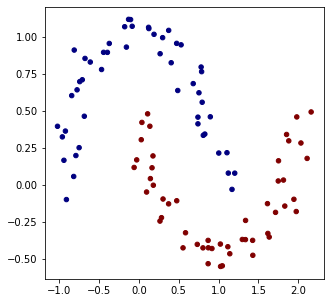

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

Next, let's define a tiny `micrograd` model with two input neurons, two hidden layers of length 16 each and an output layer with a single neuron. We then train this model for 20 steps on our training data, which results in 90%+ accuracy - not bad. We also time the run for later comparison. On my laptop the wallclock time for this experiment is roughly 20 seconds.

In [9]:
model = Model([2, 16, 16, 1])
%time model.fit(X, y, steps=20)

Loss 1.5968898068523196, accuracy 19.0%
Loss 0.5997450178762415, accuracy 81.0%
Loss 1.7421268238764351, accuracy 50.0%
Loss 2.7635911650401814, accuracy 50.0%
Loss 0.712325903508069, accuracy 52.0%
Loss 0.4264080691600425, accuracy 80.0%
Loss 0.34570297777245373, accuracy 82.0%
Loss 0.5078263756388556, accuracy 84.0%
Loss 0.39886614460998737, accuracy 84.0%
Loss 0.31082596578004223, accuracy 88.0%
Loss 0.2604193188663034, accuracy 90.0%
Loss 0.1950804210547459, accuracy 92.0%
Loss 0.20967554372932248, accuracy 91.0%
Loss 0.2095561932175058, accuracy 91.0%
Loss 0.25379694622337223, accuracy 88.0%
Loss 0.13725735148011942, accuracy 95.0%
Loss 0.13986669036613053, accuracy 95.0%
Loss 0.1548539167062905, accuracy 94.0%
Loss 0.16879899518488875, accuracy 93.0%
Loss 0.11310052401671539, accuracy 96.0%
CPU times: user 19.3 s, sys: 321 ms, total: 19.6 s
Wall time: 19.6 s


As the dataset we've chosen is 2-dimensional, it's easy to visualise the decision boundary of our classifier. Let's create a little helper function called `decision_boundary` that creates a `matplotlib` contour plot for a given model, features, and labels.

In [6]:
def decision_boundary(model, X, y):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

As you can see, the decision boundary of our model isn't perfect for the training data, but it has definitely learned something about the structure of the moons.

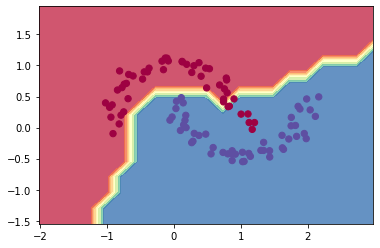

In [8]:
decision_boundary(model, X, y)

Next, let's distribute the same neural network across 4 workers using `microdist`s simple parameter servers for communication between the models. There's one "master" model that's responsible for collecting training results, and 4 workers that execute training steps and send gradient updates to a parameter server for aggregation on the master.
Note that we use the same model definition as before, but this time call the `dist_fit` method with a `num_workers` parameter - that's all.

In this experiment, we train each worker model for 10 steps. That means we half the training steps per worker compared to the previous `model`, but end up with twice as many training steps in total. On my laptop this experiment runs for around 6 seconds total.

If you look closely at the output of the model, you will see the process IDs (pid) of a total of 4 workers and their respective training accuracies, all trained in parallel.

In [15]:
dist_model = Model([2, 16, 16, 1])
%time dist_model.dist_fit(X, y, steps=10, num_workers=4)

CPU times: user 20.5 ms, sys: 7.94 ms, total: 28.4 ms
Wall time: 1 s
(worker pid=62372) Loss 1.027811428791478, accuracy 53.0%
(worker pid=62370) Loss 1.027811428791478, accuracy 53.0%
(worker pid=62368) Loss 1.027811428791478, accuracy 53.0%
(worker pid=62371) Loss 1.027811428791478, accuracy 53.0%
(worker pid=62372) Loss 9.38328027284824, accuracy 50.0%
(worker pid=62370) Loss 2.6154404990572697, accuracy 65.0%
(worker pid=62368) Loss 5.2998304802075324, accuracy 50.0%
(worker pid=62371) Loss 0.9699586348356568, accuracy 75.0%
(worker pid=62372) Loss 49.540981041297776, accuracy 50.0%
(worker pid=62370) Loss 5.29200964162616, accuracy 50.0%
(worker pid=62368) Loss 21.042753422839944, accuracy 50.0%
(worker pid=62371) Loss 1.946148220819412, accuracy 83.0%
(worker pid=62372) Loss 6.8888607705664295, accuracy 50.0%
(worker pid=62370) Loss 3.421582037285133, accuracy 72.0%
(worker pid=62368) Loss 4.963528924293082, accuracy 52.0%
(worker pid=62371) Loss 50.14373915688455, accuracy 50.0%

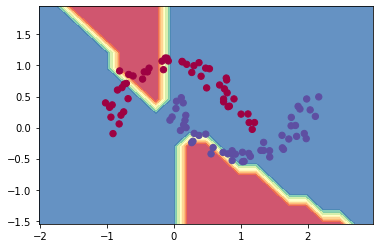

In [17]:
decision_boundary(dist_model, X, y)